In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.autograd import Variable
from torchvision.utils import make_grid
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt


# Build an Autoencoder for a human face dataset

We will use a dataset containing images of people and train an autoencoder on it. 

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [26]:

path = 'lfw/lfw'

In [27]:
transform    = transforms.Compose([transforms.ToTensor()]) 
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [28]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")


MPS device not found.


## Step 2
Each datapoint is an image. Get a sample of the data and print its dimensions and explain what each dimension means.

torch.Size([250, 250, 3])
These values indicate the Height of the image, Width of the image, and Number of color channels.


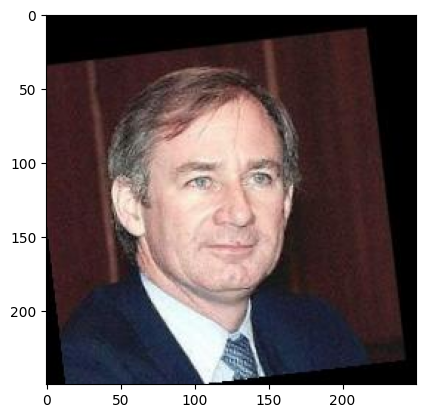

In [29]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    print("These values indicate the Height of the image, Width of the image, and Number of color channels.") #Step 2
    plt.imshow(x)
    break

# Step 3

Create a new pytorch model class for your autoencoder. You can use Conv2d, MaxPool2d, BatchNorm2d, ConvTranspose2d and Linear Layers as as well as activation functions. Optionally, you can use UpSample, AveragePool2d and Interpolate2d as well.

**Create seperate functions for the encoder and decoder.**

In [30]:
class AE(nn.Module):
    
    def __init__(self):
        super(AE, self).__init__()
        
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Encoding
        x = self.encoder(x)
        
        # Decoding
        x = self.decoder(x)
        return x

# Create the model
autoencoder = AE()

# Print the model architecture
print(autoencoder)

AE(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(64, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): Sigmoid()
  )
)


## Step 4
Create an instance of the class, pass an image to the model, print the shape of the output of the **encoder** and the **decoder**. Check the dimensions and make sure your forward path is working properly.

In [31]:
model = AE()

# Create the sample image
sample_image = torch.randn(1, 3, 250, 250)

# Forward pass through the model
encoder_output = model.encoder(sample_image)
decoder_output = model.decoder(encoder_output)

# Print the shapes of the encoder and decoder
print("Encoder output shape:", encoder_output.shape)
print("Decoder output shape:", decoder_output.shape)


Encoder output shape: torch.Size([1, 128, 62, 62])
Decoder output shape: torch.Size([1, 3, 248, 248])


##  Step 5
Print total number of parameters in the model, explain what loss function you should use, create an optimizer for training

In [32]:
# Print the total number of parameters
total_params = sum(p.numel() for p in model.parameters())
print("Total parameters in the model:", total_params)


Total parameters in the model: 151171


In [33]:
# Create the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [34]:
# Create the loss function
loss_function = nn.MSELoss()

##  Step 6
Write a training loop and start training the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [35]:
num_epochs = 10

for epoch in range(num_epochs):
    total_loss = 0.0
    
    # Use tqdm to create a progress bar (for sanity sake)
    progress_bar = tqdm(enumerate(dataloader), total=len(dataloader), desc=f'Epoch {epoch + 1}/{num_epochs}', dynamic_ncols=True)

    for batch_idx, batch in progress_bar:
        inputs, _ = batch
        inputs_resized = nn.functional.interpolate(inputs, size=(64, 64), mode='bilinear', align_corners=False)
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs_resized)
        loss = loss_function(outputs, inputs_resized)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        progress_bar.set_postfix({'Loss': loss.item()})

    # Print the average loss for the current epoch
    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Average Loss: {avg_loss}")

# Save the model
torch.save(model.state_dict(), 'autoencoder_model.pth')


Epoch 1/10: 100%|██████████████████████████████████████████████████████| 414/414 [00:23<00:00, 17.86it/s, Loss=0.00365]


Epoch 1/10, Average Loss: 0.010109155680106926


Epoch 2/10: 100%|██████████████████████████████████████████████████████| 414/414 [00:23<00:00, 17.77it/s, Loss=0.00338]


Epoch 2/10, Average Loss: 0.003928010809181285


Epoch 3/10: 100%|██████████████████████████████████████████████████████| 414/414 [00:24<00:00, 17.05it/s, Loss=0.00324]


Epoch 3/10, Average Loss: 0.0032065945546984097


Epoch 4/10: 100%|██████████████████████████████████████████████████████| 414/414 [00:23<00:00, 17.27it/s, Loss=0.00259]


Epoch 4/10, Average Loss: 0.002812060500508633


Epoch 5/10: 100%|██████████████████████████████████████████████████████| 414/414 [00:24<00:00, 17.02it/s, Loss=0.00259]


Epoch 5/10, Average Loss: 0.0025463861802475897


Epoch 6/10: 100%|██████████████████████████████████████████████████████| 414/414 [00:24<00:00, 16.87it/s, Loss=0.00221]


Epoch 6/10, Average Loss: 0.0023498759109522372


Epoch 7/10: 100%|███████████████████████████████████████████████████████| 414/414 [00:23<00:00, 17.26it/s, Loss=0.0023]


Epoch 7/10, Average Loss: 0.002214844161723313


Epoch 8/10: 100%|████████████████████████████████████████████████████████| 414/414 [00:23<00:00, 17.35it/s, Loss=0.002]


Epoch 8/10, Average Loss: 0.0021034687507789636


Epoch 9/10: 100%|██████████████████████████████████████████████████████| 414/414 [00:24<00:00, 16.89it/s, Loss=0.00258]


Epoch 9/10, Average Loss: 0.002020286261452731


Epoch 10/10: 100%|█████████████████████████████████████████████████████| 414/414 [00:24<00:00, 17.08it/s, Loss=0.00192]

Epoch 10/10, Average Loss: 0.001939149893446857


##  Step 7

Take a random image from the dataset and plot it against the reconstructed (encoded + decoded) image.

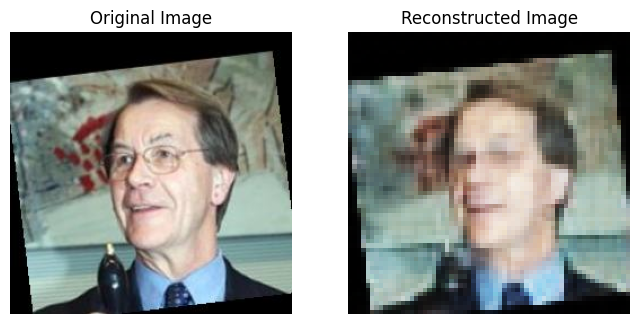

In [36]:
# Set the model to eval mode
model.eval()

# Pull a random image from the dataset
random_index = torch.randint(0, len(dataloader.dataset), (1,))
random_image, _ = dataloader.dataset[random_index]

# Resize the image to match the decoder output size
random_image_resized = nn.functional.interpolate(random_image.unsqueeze(0), size=(64, 64), mode='bilinear', align_corners=False)

# Forward pass
with torch.no_grad():
    reconstructed_image = model(random_image_resized)

# Set the model back to training mode
model.train()

# Plot the images
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Original image
axes[0].imshow(random_image.permute(1, 2, 0))
axes[0].set_title('Original Image')
axes[0].axis('off')

# Reconstructed image
axes[1].imshow(reconstructed_image.squeeze().permute(1, 2, 0))
axes[1].set_title('Reconstructed Image')
axes[1].axis('off')

plt.show()

##  Step 8

In step 7, add a small normaly distrubuted noise to the latent (hidden) representation of the input image and then decode it again. How is adding noise affecting the decoded image ?

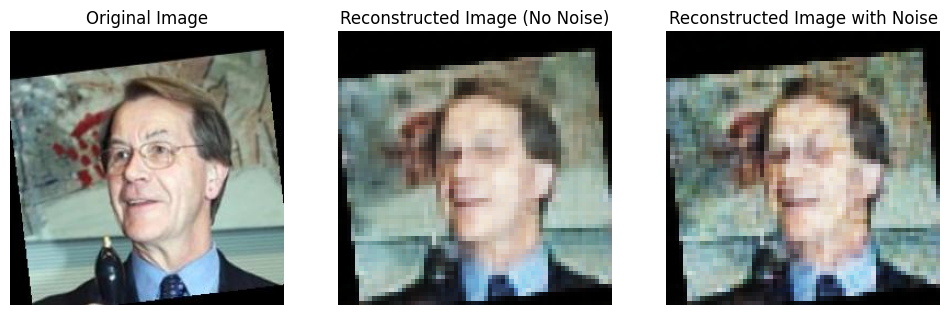

In [37]:
# Set the model to eval mode
model.eval()

# Pull a random image from the dataset
random_image, _ = dataloader.dataset[random_index]

# Resize the image to match the decoder output size
random_image_resized = nn.functional.interpolate(random_image.unsqueeze(0), size=(64, 64), mode='bilinear', align_corners=False)

# Forward pass
with torch.no_grad():
    reconstructed_image = model(random_image_resized)

with torch.no_grad():
    latent_representation = model.encoder(random_image_resized)

noise = torch.randn_like(latent_representation) * 0.1
noisy_latent_representation = latent_representation + noise

with torch.no_grad():
    reconstructed_image_with_noise = model.decoder(noisy_latent_representation)

# Set the model back to training mode
model.train()

# Plot the images
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Original image
axes[0].imshow(random_image.permute(1, 2, 0))
axes[0].set_title('Original Image')
axes[0].axis('off')

# Reconstructed image without noise
axes[1].imshow(reconstructed_image.squeeze().permute(1, 2, 0))
axes[1].set_title('Reconstructed Image (No Noise)')
axes[1].axis('off')

# Reconstructed image with noise
axes[2].imshow(reconstructed_image_with_noise.squeeze().permute(1, 2, 0))
axes[2].set_title('Reconstructed Image with Noise')
axes[2].axis('off')

plt.show()

Adding noise is making the quality of the decoded image worse.